In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

### Prepare for Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


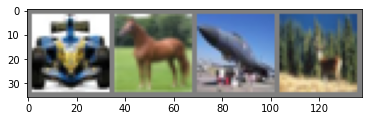

  car horse plane  deer


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Choose device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


### ResNet

In [5]:
# Load the pre-trained ResNet18 model
#net = models.resnet18(pretrained=True)
#choose amount of layers
#net = models.resnet34(pretrained=True)
net = models.resnet50(pretrained=True)

# change last layer for classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

/home/h5yoon/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/h5yoon/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Pooling

In [6]:
#pool_type = nn.MaxPool2d(kernel_size=2, stride=2)
pool_type = nn.AvgPool2d(kernel_size=2, stride=2)
for name, module in net.named_modules():
    if isinstance(module, nn.MaxPool2d) or isinstance(module, nn.AvgPool2d):
        setattr(net, name, pool_type)

### Optimizer + Loss Func

In [7]:
# cross entropy for loss func
loss_func = nn.CrossEntropyLoss()  

#opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #using SGD as optimizer
opt = optim.Adam(net.parameters(), lr=0.001) #using adam as optimizer

### Activation function

In [8]:
#net._modules['ReLU'] = nn.Sigmoid() #change to Sigmoid
net._modules['Sigmoid'] = nn.ReLU() #change to ReLU

### Train

In [9]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.958
[epoch: 0, i:   199] avg mini-batch loss: 2.589
[epoch: 0, i:   299] avg mini-batch loss: 2.661
[epoch: 0, i:   399] avg mini-batch loss: 2.698
[epoch: 0, i:   499] avg mini-batch loss: 2.650
[epoch: 0, i:   599] avg mini-batch loss: 2.736
[epoch: 0, i:   699] avg mini-batch loss: 2.496
[epoch: 0, i:   799] avg mini-batch loss: 2.619
[epoch: 0, i:   899] avg mini-batch loss: 2.591
[epoch: 0, i:   999] avg mini-batch loss: 2.557
[epoch: 0, i:  1099] avg mini-batch loss: 2.542
[epoch: 0, i:  1199] avg mini-batch loss: 2.522
[epoch: 0, i:  1299] avg mini-batch loss: 2.440
[epoch: 0, i:  1399] avg mini-batch loss: 2.466
[epoch: 0, i:  1499] avg mini-batch loss: 2.497
[epoch: 0, i:  1599] avg mini-batch loss: 2.486
[epoch: 0, i:  1699] avg mini-batch loss: 2.415
[epoch: 0, i:  1799] avg mini-batch loss: 2.425
[epoch: 0, i:  1899] avg mini-batch loss: 2.423
[epoch: 0, i:  1999] avg mini-batch loss: 2.445
[epoch: 0, i:  2099] avg mini-batch loss

### Training Loss Curve

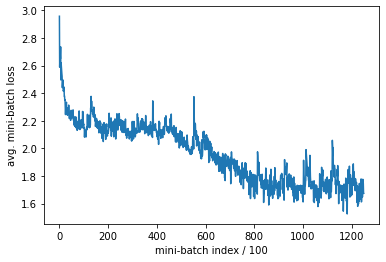

In [10]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

### Eval on Test

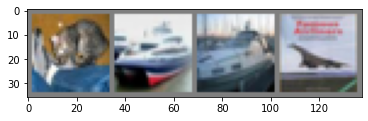

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship  ship


In [11]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

### get test acc

In [12]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


### Test acc for each

In [13]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 68 %
Accuracy of  bird : 10 %
Accuracy of   cat : 10 %
Accuracy of  deer : 22 %
Accuracy of   dog : 39 %
Accuracy of  frog : 55 %
Accuracy of horse : 47 %
Accuracy of  ship : 57 %
Accuracy of truck : 23 %
